# Assignment 4: Block Matching and Harris Corner Detection

Gruppe 2: Albrecht Oster, Linus Helfmann

## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

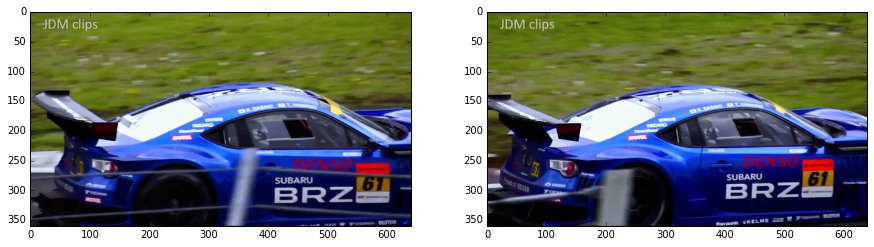

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, draw
from scipy import ndimage
import numpy as np
import cv2

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg')

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(car1)
ax2.imshow(car2)

In [2]:
BLOCK_RADIUS = 20 #radius des Quadrats das verglichen wird
COMPARE_RADIUS = 20 #wie viele pixel in jede richtung vergleichen wir
STEP_SIZE = 30 # alle wie viele Pixel nehmen wir einen messpunkt
BORDER = BLOCK_RADIUS + COMPARE_RADIUS

def SSD(image1,image2,x1,y1,x2,y2,comp_sum):
    #TODO zu nah am Rand abfangen
    sum_pixel = 0
    for x in range(-BLOCK_RADIUS, BLOCK_RADIUS+1):
        for y in range(-BLOCK_RADIUS, BLOCK_RADIUS+1):
            sum_pixel += (image1[y1+y, x1+x]-image2[y2+y, x2+x])**2
            # Performance verbesserung
            if sum_pixel > comp_sum:
                return sum_pixel
    return sum_pixel

# sucht den vektor der verschiebung zwischen zwei Bildern 
# für einen speziellen Bildpunkt
def findVector(image1,image2,x1,y1):
    x2, y2 = x1, y1
    sum_pixel = np.inf
    for x in range(-COMPARE_RADIUS, COMPARE_RADIUS+1):
        for y in range(-COMPARE_RADIUS, COMPARE_RADIUS+1):
            tempsum = SSD(image1,image2,x1,y1,x1+x,y1+y,sum_pixel)
            if tempsum < sum_pixel:
                sum_pixel= tempsum
                x2, y2 = x1+x, y1+y
    return (x2-x1, y2-y1)

# durch alle Punkte gehen und vektoren errechnen
def findAllVectors(image1,image2):
    img1 = color.rgb2gray(image1)
    img2 = color.rgb2gray(image2)
    vectors = []
    min_x = BORDER
    max_x = img1.shape[1] - BORDER
    min_y = BORDER
    max_y = img1.shape[0] - BORDER
    for x in range(min_x, max_x, STEP_SIZE):
        for y in range(min_y, max_y, STEP_SIZE):
            (a, b) = findVector(img1,img2,x,y)
            vectors.append((x,y,x+a,y+b))
    return vectors

def drawVector(image, x0, y0, x1, y1):
    liney,linex = draw.line(y0,x0,y1,x1)
    for y in range(0,liney.size-1):
        image[liney[y],linex[y]] = 1

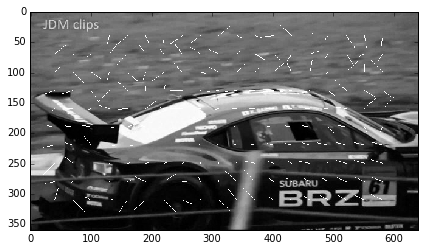

In [3]:
vectors = findAllVectors(car1,car2)
img = color.rgb2gray(car1)
for (x0,y0,x1,y1) in vectors:
    drawVector(img,x0,y0,x1,y1)
io.imshow(img)

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [4]:
def HCD(image):
    image = color.rgb2gray(image)
    
    # 1. Sx, Sy statt G_\rho^x, G_\rho^y
    Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy = Sx.T
    Ix = ndimage.convolve(image, Sx)
    Iy = ndimage.convolve(image, Sy)
    
    # 2.
    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)
    Ixy = np.multiply(Ix,Iy)
    
    # 3. 
    sigma = 1
    Sx2 = ndimage.filters.gaussian_filter(Ix2, sigma)
    Sy2 = ndimage.filters.gaussian_filter(Iy2, sigma)
    Sxy = ndimage.filters.gaussian_filter(Ixy, sigma)
    
    edgemap = np.zeros(image.shape)
    edgepoints = []
    K = 0.05
    R_THRESHOLD = 0.5
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # 4. 
            H = np.array([[Sx2[y,x],Sxy[y,x]],[Sxy[y,x],Sy2[y,x]]])
            # 5.
            R = np.linalg.det(H)-K*(np.trace(H)**2)
            if R > R_THRESHOLD:
                edgemap[y,x] = 1
                edgepoints.append([x,y])
    
    return (edgemap,np.array(edgepoints,np.float32))

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


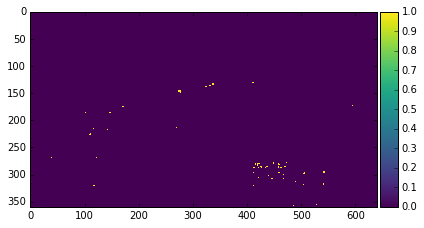

In [5]:
# Punkte finden
(edgemap,edgepoints) = HCD(car1)
io.imshow(edgemap)

In [6]:
def trackPoints(image1,image2,edgepoints):
    p1, st, err = cv2.calcOpticalFlowPyrLK(cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY), \
                            cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY), edgepoints, None)

    st = st.reshape(st.shape[0])
    good_new = p1[st==1]
    good_old = edgepoints[st==1]

    img = color.rgb2gray(image1)

    # draw the tracks
    for (new,old) in zip(good_new,good_old):
        drawVector(img,int(old[0]),int(old[1]),int(new[0]),int(new[1]))

    io.imshow(img)

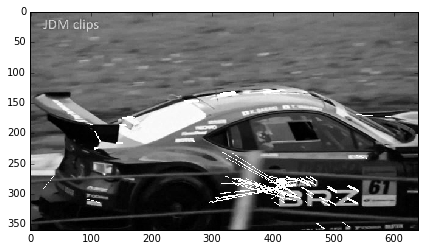

In [7]:
trackPoints(car1,car2,edgepoints)